In [1]:
###Import
import sys

#import geobayes_simple as gs
from matplotlib import pyplot as plt
from IPython.core.display import Image

%matplotlib inline
import pymc as pm
from pymc.Matplot import plot
import numpy as np
from IPython.core.pylabtools import figsize
figsize(10, 3)
import seaborn
seaborn.set_context(font_scale=2)
seaborn.set_style("white")

import scipy.optimize as sop

from pymc import graph

In [2]:
std1 = 20
std2 = 60

In [3]:
alpha = pm.Normal("alpha", -2000, 1./np.square(7.),)
beta = pm.Normal("beta", -2050, 1./np.square(25),)
gamma = pm.Normal("gamma", -2200, 1./np.square(45),)

@pm.stochastic
def layer_thickness1(value = 0, alpha = alpha, beta = beta):
    a = alpha-beta
    return pm.normal_like(a, 25., 1./np.square(std1))

@pm.stochastic
def layer_thickness2(value = 0,  beta = beta, gamma = gamma):
    b = beta-gamma
    return pm.normal_like(b, 180., 1./np.square(std2))

model = pm.Model([alpha, beta, gamma, layer_thickness1, layer_thickness2])

M = pm.MCMC(model)

In [4]:
M.sample(iter=10000, burn = 1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 4.0 sec

In [5]:
M.trace('beta')[:].shape

(9000,)

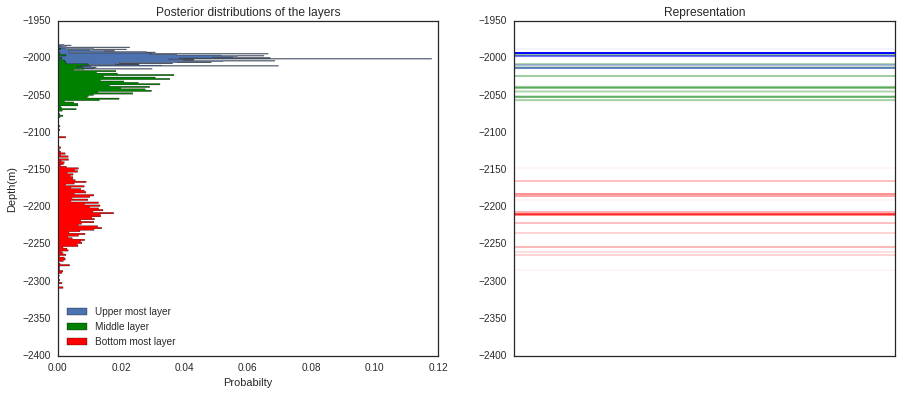

In [6]:
import matplotlib.mlab as mlab
figsize(15,6)
fig, ax = plt.subplots(1, 2)
alpha_samples = M.trace('alpha')[:]
beta_samples = M.trace('beta')[:]
gamma_samples = M.trace('gamma')[:]

alpha_samples, alpha_samples_all = M.trace('alpha')[-80:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-80:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-80:], M.trace('gamma')[:]

parameters = zip(alpha_samples, beta_samples, gamma_samples)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all)
ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=60, alpha=1,
    label="Upper most layer", normed=True,  orientation="horizontal")
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=60, alpha=1,
    label="Middle layer", normed=True, color = "g",  orientation="horizontal")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=120, alpha=1,
 label="Bottom most layer", normed=True, color = "r", orientation="horizontal")
#x = np.linspace(-140,-220)
#ax[0].plot(mlab.normpdf(x, -180, 10),x, linewidth = 3, label = "$y_1$")
#y = np.linspace(-240,-320)
#ax[0].plot(mlab.normpdf(y, -280, 15),y,linewidth = 3, label = "$y_2$")
#ax[0].invert_xaxis()
ax[0].legend(loc = 0)
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_ylabel("Depth(m)")
ax[0].set_xlabel("Probabilty")
ax[0].set_ylim([-2400,-1950])

ax[1].set_title("Representation")
ax[1].set_ylim([-2400,-1950])
ax[1].xaxis.set_visible(False)

for i in range(100):
    ax[1].axhline(alpha_samples_all[-i], alpha = 0.05)
    ax[1].axhline(beta_samples_all[-i], c = "g", alpha = 0.05)
    ax[1].axhline(gamma_samples_all[-i],c = "r", alpha = 0.05)

In [7]:
#seal_top = alpha_samples_all
#res_top = beta_samples_all
#res_bottom = gamma_samples_all
#
#seal_thickness = (seal_top - res_top)
#reservoir_thickness = (res_top - res_bottom)
#reservoir_depth = beta_samples_all
#
#print(seal_thickness)
#print(res_top.shape)

In [8]:
th_v = 20 #value per meter reservoir thickness
dp_c = 1  #cost per meter depth
seal_to = 20  #seal safety threshold

#@pm.deterministic
#def res_thickness(res_top=res_top, res_bottom=res_bottom):
#    return np.abs(res_top - res_bottom)

#@pm.deterministic
#def s_thickness(seal_top=seal_top, res_top=res_top):
#    return np.abs(seal_top - res_top)

#@pm.deterministic
#def value_if_seal(res_thickness=res_thickness, res_depth=res_top, \
#                  th_v=th_v, dp_c=dp_c):
#    return (th_v * res_thickness + (dp_c * res_depth))
seal_top = pm.Normal("seal_top", -2000, 1./np.square(7.),)
res_top = pm.Normal("res_top", -2050, 1./np.square(25),)
res_bottom = pm.Normal("res_bottom", -2200, 1./np.square(45),)

@pm.stochastic
def layer_thickness1(value = 0, alpha = seal_top, beta = res_top):
    a = alpha-beta
    return pm.normal_like(a, 25., 1./np.square(std1))

@pm.stochastic
def layer_thickness2(value = 0,  beta = res_top, gamma = res_bottom):
    b = beta-gamma
    return pm.normal_like(b, 180., 1./np.square(std2))

@pm.deterministic
def value_if_seal(res_bottom=res_bottom, res_depth=res_top, \
                  th_v=th_v, dp_c=dp_c):
    return (th_v * (res_depth - res_bottom) + (dp_c * res_depth))

@pm.deterministic
def value_if_seal_fail(res_depth=res_top, dp_c=dp_c):
    return (dp_c * res_depth)

@pm.deterministic
def true_quality(seal_top=seal_top, res_top=res_top,
                 dp_c=dp_c, res_depth=res_top, 
                 value_if_seal = value_if_seal, value_if_seal_fail=value_if_seal_fail):
    #print(seal_top, res_top)
    seal_th = seal_top - res_top
    seal_failure = seal_th < seal_to
    x = np.zeros_like(seal_top)
    x[~seal_failure] = value_if_seal[~seal_failure]
    x[seal_failure] = value_if_seal_fail[seal_failure]
    #if seal_th >= 20:
    #    #print (seal_th)
    #    x = value_if_seal
    #else:
    #    x = (dp_c * res_depth)
    #print (x)
    #print(x.shape)
    return x

model = pm.Model([true_quality, value_if_seal, value_if_seal_fail, layer_thickness1, layer_thickness2, res_top, res_bottom, seal_top])
#model = pm.Model([true_quality, res_thickness, s_thickness, value_if_seal, res_top, res_bottom, seal_top])



M = pm.MCMC(model)
M.sample(iter=10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 4.2 sec

In [9]:
M.trace("true_quality")[:]

array([-2014.50297922, -2014.50297922, -2014.50297922, ...,  1423.51252836,
        1423.51252836,  1409.81170095])

In [10]:
#res_th_samples2 = M.trace("res_thickness")[:]
#seal_top_samples = M.trace("seal_top")[:]
#res_top_samples = M.trace("res_top")[:]
#res_dp_samples = M.trace("res_top")[:]
#res_bt_samples = M.trace("res_bottom")[:]
res_quality_samples2 = M.trace("true_quality")[:]
M.trace("true_quality")[:].shape

(9000,)

625.801133975


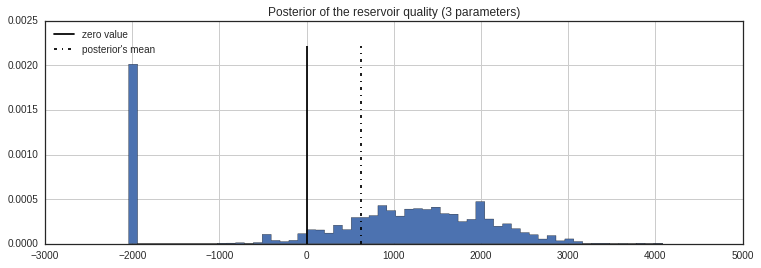

In [11]:
figsize(12.5, 4)

#x = np.linspace(-2000, 4000)
#plt.plot(x, stats.norm.pdf(x, 2000, 1000), c="k", lw=2,
#         label="prior dist. of quality")

_hist = plt.hist(res_quality_samples2, bins=60, normed=True, histtype="stepfilled")
plt.title("Posterior of the reservoir quality (3 parameters)")
plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero value",
           linestyles="-")
plt.vlines(res_quality_samples2.mean(), 0, 1.1 * np.max(_hist[0]),
           label="posterior's mean", linestyles="-.")
print(res_quality_samples2.mean())
#plt.ylim((0,0.0005))
#plt.xlim((-2000,4000))
plt.legend(loc="upper left");
plt.grid()

In [22]:
negative_cases2 = (res_quality_samples2<0).sum()/9000
print("Portion of cases in which the quality is negative:",negative_cases2)

Portion of cases in which the quality is negative: 0.241888888889


In [19]:
res_quality2 = res_quality_samples2
#seal_quality2 = seal_top_samples - res_top_samples
estimates_q = np.arange(-3000,5000,5)
risks_q = np.arange(10,60,10)
print(risks_q)
print(risks_q[2])

[10 20 30 40 50]
30


In [20]:
def res_quality_loss(estimate_q, true_q, risk_q):
        loss_q = np.zeros_like(true_q)
        underest = (estimate_q < true_q) & (estimate_q >= 0)
        underest_bad = (estimate_q <= 0) & (true_q > 0)
        #underest_good = estimate_q < true_q and true_q <= 0
        overest = (estimate_q > true_q) & (true_q >= 0) #and true_q >= 0
        overest_bad = (estimate_q > 0) & (true_q <= 0)
        #overest_good = estimate_q > true_q and estimate_q <= 0
        loss_q[underest] = (true_q[underest] - estimate_q)
        loss_q[underest_bad] = true_q[underest_bad]
        #loss_q[underest_good] = 0
        loss_q[overest] = (estimate_q - true_q[overest])*(risk_q/(risks_q[2]))
        loss_q[overest_bad] = (estimate_q - true_q[overest_bad])*(risk_q/(risks_q[2]+0.7))
        #loss_q[overest_good] = 0
        return loss_q/10000000

Bayes action (minimum) at risk r 10: 1715.73
Bayes action (minimum) at risk r 20: 1317.98
Bayes action (minimum) at risk r 30: 1039.86
Bayes action (minimum) at risk r 40: 869.43
Bayes action (minimum) at risk r 50: 700.93
Mean of posterior distribution: 625


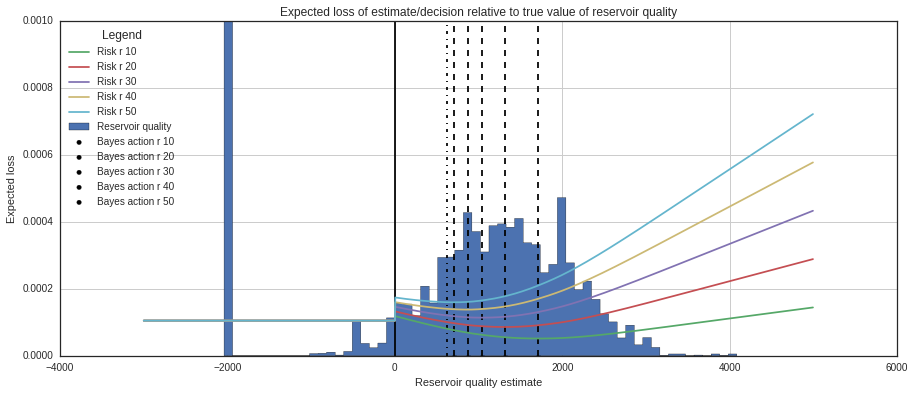

In [21]:
figsize(15, 6)
  
expected_loss_q = lambda estimate_q, risk_q: res_quality_loss(estimate_q, res_quality2, risk_q).mean()

plt.hist((res_quality2), histtype='stepfilled', bins=60, alpha=1,
    label="Reservoir quality", normed=True)

for r in risks_q:
    loss = [expected_loss_q(e, r) for e in estimates_q]
    _min_results = sop.fmin(expected_loss_q, 40, args=(r,),disp = False)
    plt.plot(estimates_q, loss, label = "Risk r "+str(r))
    plt.scatter(_min_results, 0, s = 20, color = 'black', label = "Bayes action r "+str(r))
    plt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    print("Bayes action (minimum) at risk r %d: %.2f" % (r, _min_results))
    #print("Expected loss at minimum: %d" % (loss[_min_results]))

print("Mean of posterior distribution: %d" % (res_quality_samples2.mean()))
    
plt.title(r"""Expected loss of estimate/decision relative to true value of reservoir quality""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero value",
           linestyles="-")
plt.vlines(res_quality_samples2.mean(), 0, 1.1 * np.max(_hist[0]),
           label="posterior's mean", linestyles="-.")
plt.xlabel("Reservoir quality estimate")
plt.ylabel("Expected loss")
#plt.xlim(-20, 400)
plt.ylim(0,0.001)
plt.grid()

Plotting value_if_seal
Plotting true_quality
Plotting seal_top
Plotting layer_thickness2
Plotting res_top
Plotting value_if_seal_fail
Plotting res_bottom
Plotting layer_thickness1


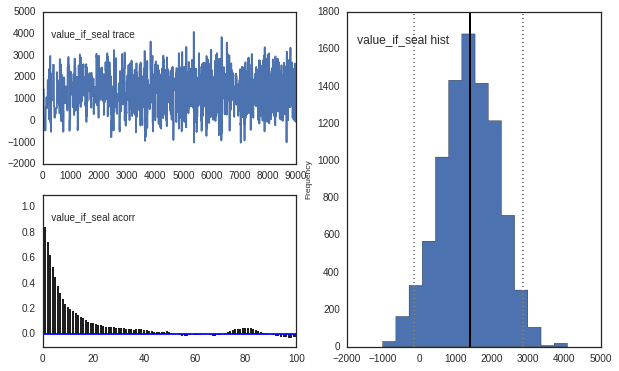

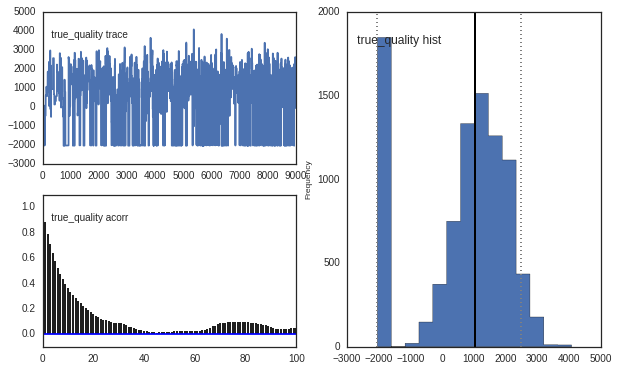

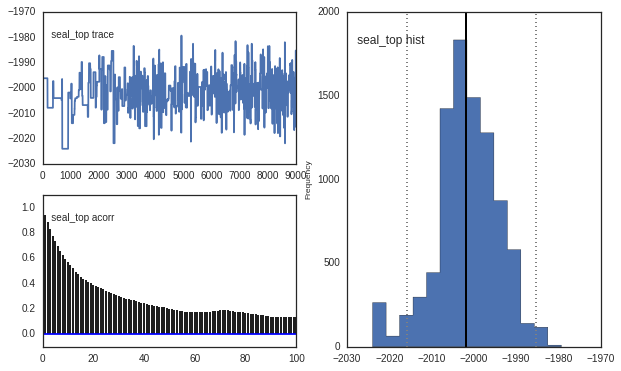

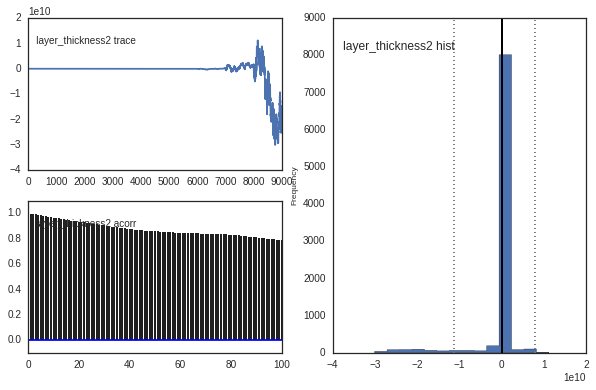

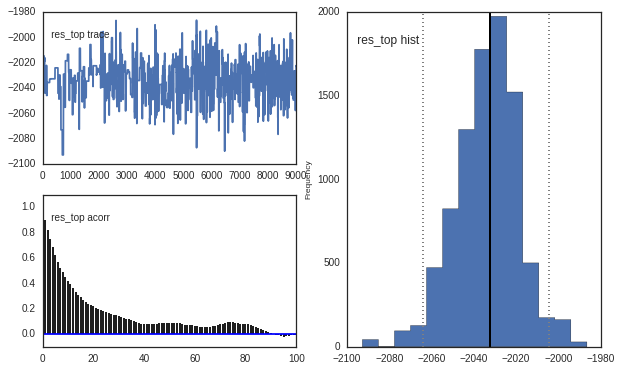

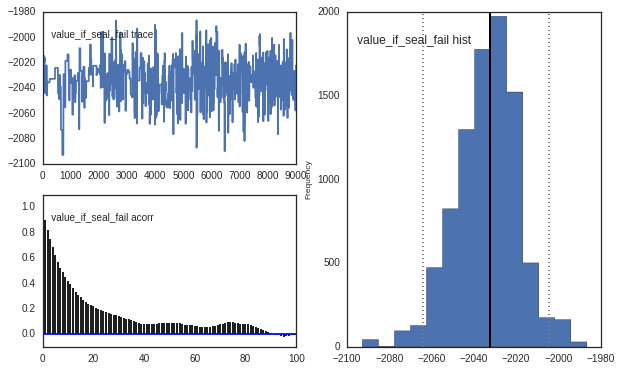

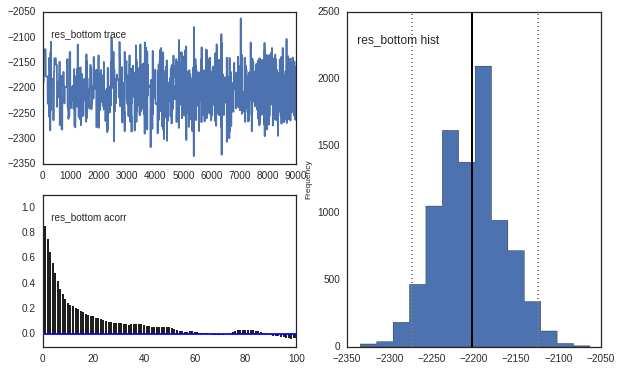

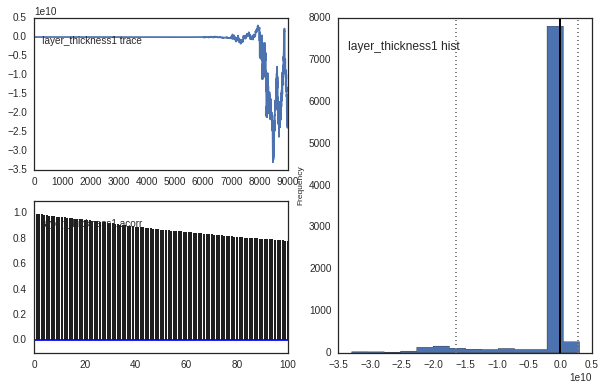

In [16]:
plot(M)